In [1]:
from sklearn import ensemble, metrics
from sklearn.model_selection import cross_validate
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

In [6]:
triplexes = pd.read_csv('basetriples2.csv', header=0, sep='\t')
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.A.22.R.A.36.R.G.48.,-_-_-,33.73_39.19_14.5,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
1,1b23.cif1_R,120,R.A.22.R.G.27.R.G.48.,-_-_-,23.6_22.89_14.5,0,0,1,0,1,...,0,0,0,0,0,0,0,5,0,0
2,1b23.cif1_R,0,R.G.19.R.G.57.R.C.69.,-_-_-,6.31_36.36_36.59,0,0,1,0,0,...,1,0,0,0,1,0,0,4,1,0
3,1b23.cif1_R,0,R.H2U.20.R.U.43.R.5MU.54.,-_-_-,24.47_37.47_24.2,0,0,1,0,0,...,1,0,0,0,1,0,0,7,1,0
4,1b23.cif1_R,0,R.C.44.R.G.52.R.C.62.,-_cWW_-,29.87_10.48_32.96,0,1,0,1,0,...,0,0,0,0,0,0,0,7,1,0


In [7]:
triplexes = triplexes.loc[triplexes['pdb_chain'] != '4kqy.cif1_A']

In [14]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.A.22.R.A.36.R.G.48.,-_-_-,33.73_39.19_14.5,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
1,1b23.cif1_R,120,R.A.22.R.G.27.R.G.48.,-_-_-,23.6_22.89_14.5,0,0,1,0,1,...,0,0,0,0,0,0,0,5,0,0
2,1b23.cif1_R,0,R.G.19.R.G.57.R.C.69.,-_-_-,6.31_36.36_36.59,0,0,1,0,0,...,1,0,0,0,1,0,0,4,1,0
3,1b23.cif1_R,0,R.H2U.20.R.U.43.R.5MU.54.,-_-_-,24.47_37.47_24.2,0,0,1,0,0,...,1,0,0,0,1,0,0,7,1,0
4,1b23.cif1_R,0,R.C.44.R.G.52.R.C.62.,-_cWW_-,29.87_10.48_32.96,0,1,0,1,0,...,0,0,0,0,0,0,0,7,1,0


In [3]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    
    
    
def probability_density(y_prob, y):
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')
    plt.show()


# Accepted1

In [8]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [9]:
triplexes_test = pd.read_csv('rna_features_accepted1.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [10]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

In [11]:
rf_classifier.fit(triplexes_data, triplexes_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [12]:
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)

array([[100,   0],
       [  7,   0]], dtype=int64)

In [15]:
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.9099999999999999


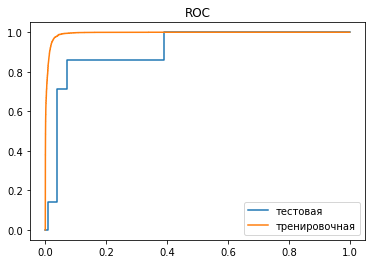

Распределение вероятностей для тренировочной выборки


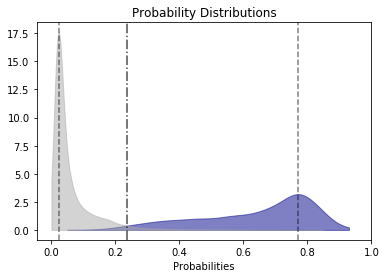

Распределение вероятностей для тестовой выборки


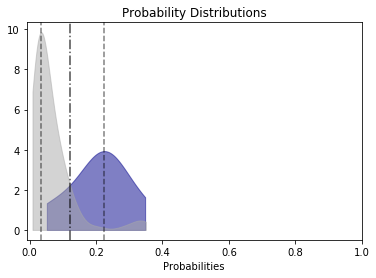


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

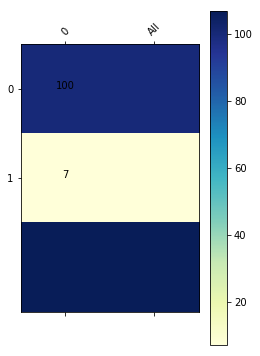

In [16]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")

# Accepted2

In [22]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [26]:
triplexes_test = pd.read_csv('rna_features_accepted2.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [27]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)
rf_classifier.fit(triplexes_data, triplexes_target)
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.9099999999999999


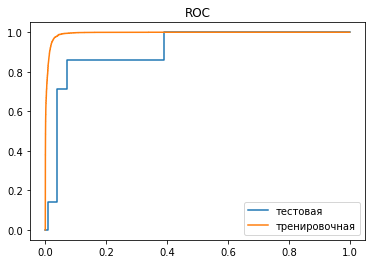

Распределение вероятностей для тренировочной выборки


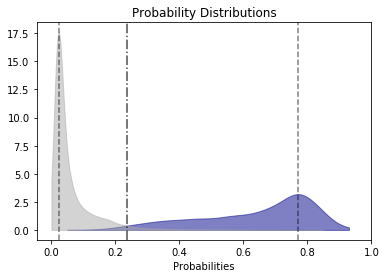

Распределение вероятностей для тестовой выборки


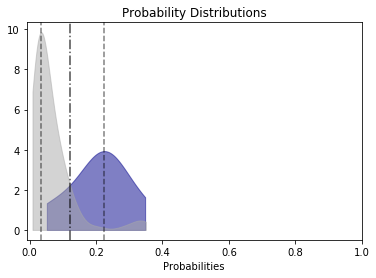


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

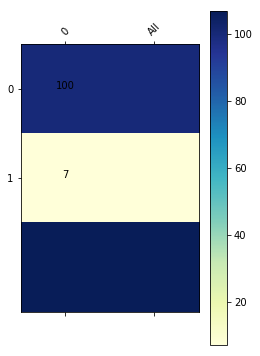

In [25]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")

# Accepted3

In [36]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]


In [37]:
triplexes_test = pd.read_csv('rna_features_accepted3.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [38]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)
rf_classifier.fit(triplexes_data, triplexes_target)
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.9128571428571428


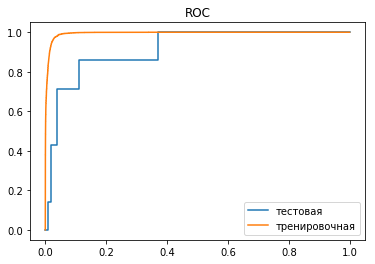

Распределение вероятностей для тренировочной выборки


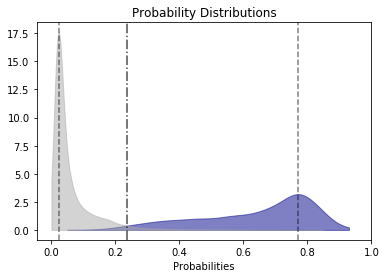

Распределение вероятностей для тестовой выборки


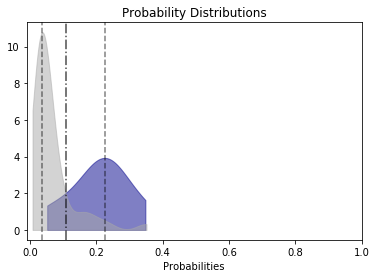


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

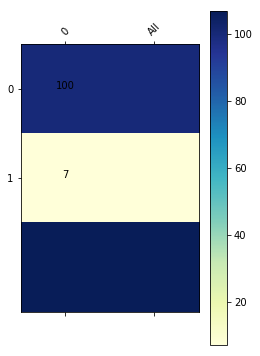

In [39]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")

# Predicted1

In [17]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [21]:
triplexes_data.head()

,same12,local12,longrange12,same23,local23,longrange23,same13,local13,longrange13,a1m5,...,u3p5,s3p5,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5
0,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,5
1,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,5
2,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,4
3,0,0,1,0,0,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,7
4,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,7


In [18]:
triplexes_test = pd.read_csv('rna_features_predicted1.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [19]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)
rf_classifier.fit(triplexes_data, triplexes_target)
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.9042857142857144


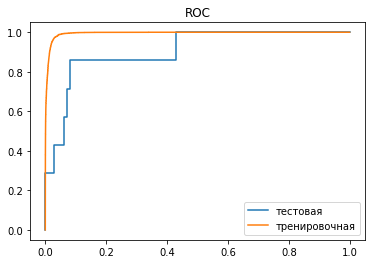

Распределение вероятностей для тренировочной выборки


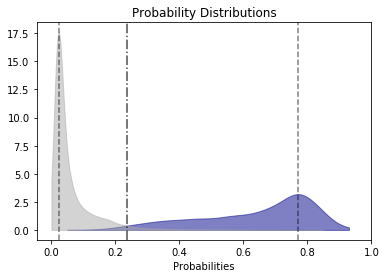

Распределение вероятностей для тестовой выборки


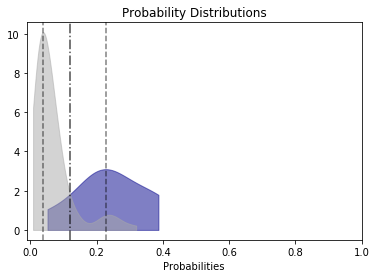


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

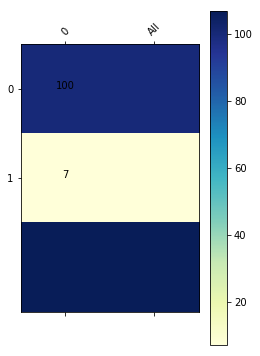

In [20]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")

# Predicted2

In [32]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [33]:
triplexes_test = pd.read_csv('rna_features_predicted2.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [34]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)
rf_classifier.fit(triplexes_data, triplexes_target)
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.9571428571428571


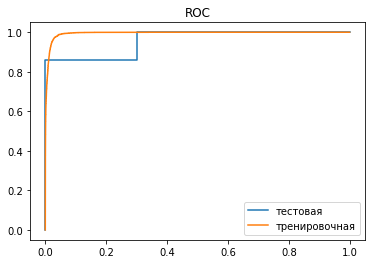

Распределение вероятностей для тренировочной выборки


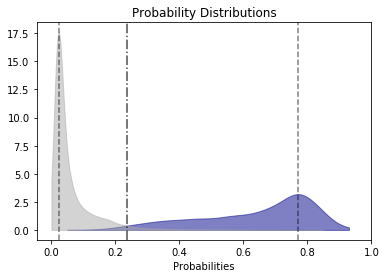

Распределение вероятностей для тестовой выборки


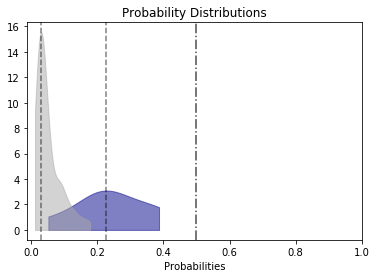


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

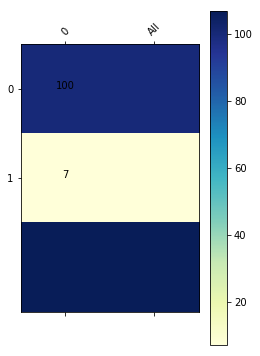

In [35]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")

# Predicted3

In [28]:
triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [29]:
triplexes_test = pd.read_csv('rna_features_predicted3.csv', sep='\t')

triplexes_test_target = [0] * 100
real = [1] * 7
triplexes_test_target = triplexes_test_target + real

triplexes_test['new_col'] = np.array(triplexes_test_target)

triplexes_test_target = triplexes_test.iloc[:, 472]
triplexes_test_data = triplexes_test.iloc[:, 1:471]


In [30]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)
rf_classifier.fit(triplexes_data, triplexes_target)
prediction_result = rf_classifier.predict(triplexes_test_data)
predict_proba = rf_classifier.predict_proba(triplexes_test_data)
confusion_matrix(triplexes_test_target, prediction_result)
print(prediction_result)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


AUC_TRAIN =  0.9948237632326592
AUC =  0.8942857142857144


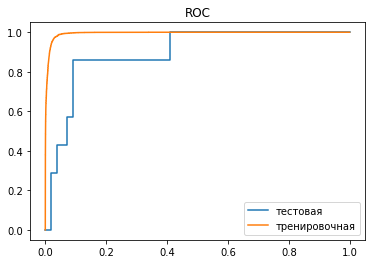

Распределение вероятностей для тренировочной выборки


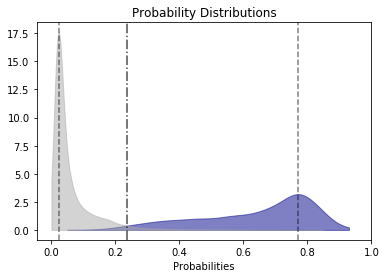

Распределение вероятностей для тестовой выборки


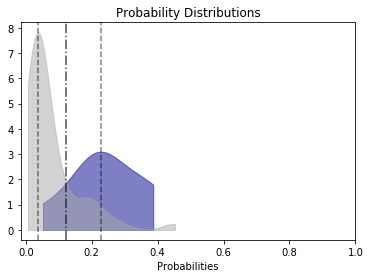


[[100   0]
 [  7   0]]
CONFUSION MATRIX
Predicted    0  All
Actual             
0          100  100
1            7    7
All        107  107


KeyError: 1

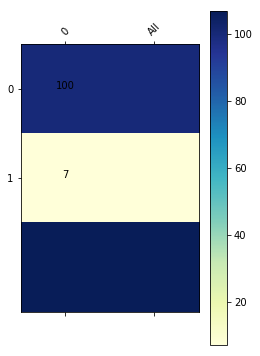

In [31]:
#TRY TO PREDICT TRAIN
prediction_train = rf_classifier.predict(triplexes_data)
prediction_prob_train = rf_classifier.predict_proba(triplexes_data)
fpr_train, tpr_train, _ = metrics.roc_curve(triplexes_target,  prediction_prob_train[:, 1])
auc_train = metrics.roc_auc_score(triplexes_target, prediction_prob_train[:, 1])
print("AUC_TRAIN = ", auc_train)



fpr, tpr, _ = metrics.roc_curve(triplexes_test_target,  predict_proba[:, 1])
auc = metrics.roc_auc_score(triplexes_test_target, predict_proba[:, 1])
print("AUC = ", auc)
line_test, = plt.plot(fpr, tpr, label='тестовая')
line_train, = plt.plot(fpr_train, tpr_train, label='тренировочная')
plt.legend( [line_test, line_train], ['тестовая', 'тренировочная'], loc = 4)
plt.title("ROC")
plt.show()
    
print("Распределение вероятностей для тренировочной выборки")
probability_density(prediction_prob_train[:, 1], triplexes_target)
print("Распределение вероятностей для тестовой выборки")
probability_density(predict_proba[:, 1], triplexes_test_target)
    
print("")
print(confusion_matrix(triplexes_test_target, prediction_result))
plot_confusion_matrix(pd.crosstab(triplexes_test_target, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))


print("")
print("REPORT")
print(classification_report(triplexes_test_target, prediction_result))
print("ACCURACY = ", accuracy_score(triplexes_test_target, prediction_result))
print("-----------------")